# RFID Radio Propagation Analytics
This notebook is aimed to demostrate physical computation that is used for Bit Error Probability (BER) evaluation.

In [1]:
%matplotlib notebook
%pylab
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from pyrfidphy import channel as ch
# import pyradise as prs

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


### Parameters initialization
Here are the parameters of the model, which are as follows:
 * radio media (environment) parameters;
 * parameters of reader antenna system;
 * parameters of tag antenna system.

In [2]:
# environment parameters
speed_of_light = 2.99792458 * 10e8
frequency = 860*10e6
wave_length = speed_of_light / frequency
thermal_noise = -116 #dBm
permittivity = 15
conductivity = 0.03

# reader paramters
reader_height = 5.0 #m
reader_angle  = pi/4
reader_tx_power = 31.5 #dBm
reader_antenna_gain = 6 #dBi
reader_noise  = -80 #dBm
reader_cabel_loss = -2 

# tag parameters
tag_speed = 20 #mps
tag_height = 0.5 #m
tag_angle  = pi/2
tag_antenna_gain = 2 #dBi 
tag_modulation_loss = -12.0 #dB
# tag_sensitivity=-17.5 #dBm
tag_sensitivity=-25 #dBm

# mutual parameters
polarization_loss = -3.0 #dB
ceil_height = 6

Define an utility function performing creation of 2D-space-time array.  

In [3]:

def make_space_time_greed_(distance, time, function, **kwargs):
    return np.array([[function(distance=d, time=t, **kwargs) for d in distance] for t in time])

### Wrappers for functions computing antenna radiation pattern (RP) and reflection coefficients.

Radiation pattern for a patch antenna $L \times W$:

$$ \Gamma(\theta, \phi) = \left| 
	\frac{\sin{kW\sin{\theta}\sin{\phi}}}{kW\sin{\theta}\sin{\phi}}
		\cos{kL\sin{\theta}\cos{\phi}} \right| \times
		\sqrt{\cos^2{\phi} + \cos^2{\theta}\sin^2{\phi}}, $$

where $\theta$ is an elevating angle, and a reader antenna, $\phi$ is an azimuth angle, $k$ is a wave number.

Reflection coefficient is given by the following formula:

$$ R = \frac{\sin\phi - \sqrt{C}}{\sin\phi + \sqrt{C}} $$

where $\phi$ is a grazing angle, $C$ defined by the following expression:

$$ C = \eta - \cos^2\phi \text{ for horizontal polarization,} $$
$$ C = \frac{\eta - \cos^2\phi}{\eta^2} \text{for vertical one.} $$ 

$$\eta = \epsilon_r(f)-j60\lambda\sigma(f), $$

where $\epsilon_r(f)$ is a relative permittivity of a ground surface at the frequency $f$, $\sigma(f)$ is a conductivity.

In [4]:
def patch_rp_(theta, phi):
    return ch.patch_rp(azimuth=theta, tilt=phi, wavelen=wave_length, width=wave_length/2, length=wave_length/2)

def reflection_paral_(phi):
    return ch.reflection(grazing_angle=phi, polarization=1., permittivity=permittivity, 
                          conductivity=conductivity, wavelen=wave_length)

def reflection_perp_(phi):
    return ch.reflection(grazing_angle=phi, polarization=0., permittivity=permittivity, 
                          conductivity=conductivity, wavelen=wave_length)

def reflection_circ_(phi):
    return ch.reflection(grazing_angle=phi, polarization=.5, permittivity=permittivity, 
                          conductivity=conductivity, wavelen=wave_length)

### Path loss and Link budget computation

Path loss is computated in assuption of multi-ray propagation media, presence of movement leading to Doppler's effect consideration, antennas radiation patterns and cmoplex reflection coefficient. The formula obtained are as follows:

$$
A_{pl} = \left(\frac{\lambda}{4\pi}\right)^2
	\left|\sum\limits_{i=0}^{N} \frac{R_i\Gamma_i}{d_i} 
		e^{-jk(d_i-\upsilon t \cos{\psi_i})}\right|^2, $$

where $c$ is a speed of light, $\upsilon$ is a relative speed of a receiver, $\psi_i$ is an angle between the wave vector $\vec{k_i}$ of $i$-th ray and the direction of movement, $\lambda$ is a wave length, $d_i$ is a length of $i$-th path, $R_i$ is a reflection coefficient of $i$-th ray (for line-of-sight ray we assumed $R_0 = 1$) and $\Gamma_i = \Gamma_i^{(r)}\Gamma_i^{(t)}$ is a coefficient correspond to a reader and a tag antenna radiation patterns properly.

For the presence computation a  number of rays $N$ equals to 1, thus the formula modulate two-ray propagation wih one reflected component, non line-of-site (NLoS) and LoS component.


The power received from the reader at the tag side is:

$$ P_r^{(t)} = P_t^{(r)} G^{(r)} A_{pl}^{(d)} A_{pol} G^{(t)}, $$

where $P_t^{(r)}$ is a reader transmission power, $G^{(r)}$ is an antenna gain, $A_{pl}^{(d)}$ is a path loss attenuation, $A_{pol}$ is a polarization loss, $G^{(t)}$ is a tag antenna has gain. If this power is lower the tag sensitivity $P_s^{(t)}$ the tag does not power up and will not able to communicate with the reader. Otherwise the tag modulate a backscattering signal $P_t^{(t)}$. The signal received at the reader side is:

$$ P_r^{(r)} = P_r^{(t)} G^{(t)} A_{bs} A_{pl}^{(r)} A_{pol} G^{(r)}, $$

where $A_{bs}$ is a backscattering loss caused by modulation loss, impedance mismatch, etc.

In [5]:
tx_position_3d        = np.array([0,0,reader_height])
tx_direction_theta_3d = np.array([np.sin(reader_angle), 0, -np.cos(reader_angle)])
tx_direction_phi_3d   = np.array([0,1,0])
tx_velocity_3d        = np.array([0,0,0])

rx_direction_theta_3d = np.array([-1,0,0])
rx_direction_phi_3d   = np.array([0,-1,0])

def two_ray_3d_(distance, time, speed, polarization):
    return ch.two_ray_path_loss_3d(time=time, ground_reflection=ch.reflection, 
            polarization=polarization, permittivity=permittivity, conductivity=conductivity,
            tx_pos=tx_position_3d, tx_dir_theta=tx_direction_theta_3d, tx_dir_phi=tx_direction_phi_3d, 
                                    tx_velocity=tx_velocity_3d, tx_rp=ch.patch_rp,
            rx_pos=np.array([distance,0,tag_height]), rx_dir_theta=rx_direction_theta_3d, rx_dir_phi=rx_direction_phi_3d, 
                                    rx_velocity=np.array([-speed,0,0]), rx_rp=ch.dipole_rp, 
            wavelen=wave_length, width=wave_length/2, length=wave_length/2)


def rx_power_tag_(pathloss):
    return (reader_tx_power + reader_antenna_gain + reader_cabel_loss + 
            pathloss + tag_antenna_gain + polarization_loss)

def tx_power_tag_(rx_power_tag):
    return rx_power_tag + tag_modulation_loss if rx_power_tag >= tag_sensitivity else thermal_noise

def rx_power_reader_(pathloss, tx_power_tag):    
    return (tx_power_tag + tag_antenna_gain + pathloss + polarization_loss +
                reader_cabel_loss + reader_antenna_gain) if tx_power_tag >= reader_noise else thermal_noise


def rx_power_tag_complete_3d_(distance, time, speed):
    pathloss_fwd = ch.lin2db(two_ray_3d_(distance, time, speed, 0.5))  # computing path loss from reader to tag 
    return rx_power_tag_(pathloss_fwd)


def tx_power_tag_complete_3d_(distance, time, speed):
    rx_power_tag = rx_power_tag_complete_3d_(distance, time, speed)
    return rx_power_tag + tag_modulation_loss if rx_power_tag >= tag_sensitivity else thermal_noise


def rx_power_reader_complete_3d_(distance, time, speed):
    pathloss_fwd = ch.lin2db(two_ray_3d_(distance, time, speed, .5))  # computing path loss from reader to tag 
    rx_power_tag = rx_power_tag_(pathloss_fwd)                      # computing RX power at tag
    tx_power_tag = tx_power_tag_(rx_power_tag)                      # computing TX power of tag
    pathloss_bwd = ch.lin2db(two_ray_3d_(distance, time, speed, 1.))  # computing path loss from tag to reader
    return rx_power_reader_(pathloss_bwd, tx_power_tag)


def snr_3d_(distance, time, speed):
    rx_power = rx_power_reader_complete_3d_(distance, time, speed)
    return ch.signal2noise(rx_power=rx_power, noise_power=reader_noise)


def ber_over_awgn_3d_(distance, time, speed):
    snr = snr_3d_(distance, time, speed)
    sync_angle = ch.sync_angle(snr=snr, preamble_duration=825e-6)
    snr_extended = ch.snr_extended(snr=snr, sync_phi=sync_angle, symbol_duration=9.375e-6, miller=4)
    return ch.ber_over_awgn(snr=snr_extended)


def ber_over_rayleigh_3d_(distance, time, speed):
    snr = snr_3d_(distance, time, speed)
    sync_angle = ch.sync_angle(snr=snr, preamble_duration=825e-6)
    snr_extended = ch.snr_extended(snr=snr, sync_phi=sync_angle, symbol_duration=4.6875e-6, miller=4)
    return ch.ber_over_rayleigh(snr=snr_extended)

Here are computation of the antenna gain obtained from the specific radiation pattern given.

In [6]:
#
# Antenna gain computation
#
def antenna_gain_(radiation_pattern, theta, **kwargs):
    max_gain  = radiation_pattern(azimuth=0, **kwargs)
    mean_gain = np.sum([radiation_pattern(azimuth=t, **kwargs) for t in theta]) / theta.size
    return ch.lin2db(max_gain / mean_gain)

def antenna_gain_2d_(radiation_pattern, theta, tilt, **kwargs):
    max_gain  = radiation_pattern(0, tilt, **kwargs)
    mean_gain = np.sum([radiation_pattern(t, tilt, **kwargs) for t in theta]) / theta.size
    return ch.lin2db(max_gain / mean_gain)

theta = np.linspace(-pi, pi, num=100)

gain_iso = antenna_gain_(ch.isotropic_rp, theta)
gain_dip = antenna_gain_(ch.dipole_rp, theta)
gain_arr = antenna_gain_(ch.array_dipole_rp, theta, n=2)
gain_hel = antenna_gain_(ch.helix_rp, theta, n=3)

print(gain_iso, gain_dip, gain_arr, gain_hel)

gain_patch_0 = antenna_gain_2d_(patch_rp_, theta, 0.0)
gain_patch_1 = antenna_gain_2d_(patch_rp_, theta, pi/6)
gain_patch_2 = antenna_gain_2d_(patch_rp_, theta, pi/4)
gain_patch_3 = antenna_gain_2d_(patch_rp_, theta, pi/3)
gain_patch_4 = antenna_gain_2d_(patch_rp_, theta, pi/12*5)

print(gain_patch_0, gain_patch_1, gain_patch_2, gain_patch_3, gain_patch_4)

0.0 5.349029975306875 6.314535216429676 5.392705253793354
6.314535216429675 5.67962938579154 5.334393666807177 5.252871482124313 5.417786106090564


### Further different computation examples are presented

Examples of reflection coefficient computation versus different angles.

<IPython.core.display.Javascript object>


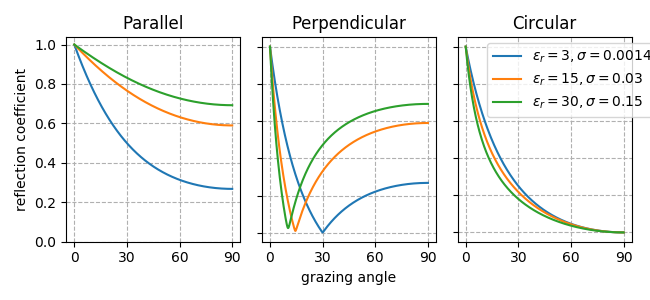

In [122]:
plt.figure(figsize=(6.5, 3.))

ax = [0] * 3
for i, title in enumerate(['Parallel', 'Perpendicular', 'Circular']):

    ax[i] = plt.subplot2grid((1,3), (0,i))
    ax[i].set_title(title)
    ax[i].set_xticks(np.arange(4) * 30)
    ax[i].set_yticks(np.arange(6) / 5.)
    ax[i].grid(linestyle='--')

label_str = "$\epsilon_{{r}}={}, \sigma={}$"
angle = np.linspace(0.0, pi/2, num=500)

def reflection(polarization, permittivity, conductivity): 
    return [np.abs(ch.reflection(
        grazing_angle=t, polarization=polarization, permittivity=permittivity, 
        conductivity=conductivity, wavelen=wave_length)) for t in angle]

for i, (perm, cond) in enumerate([(3, .0014), (15, .03), (30, .15),]):

    ax[0].plot(angle * 180 / np.pi, reflection(1., perm, cond))
    ax[1].plot(angle * 180 / np.pi, reflection(.0, perm, cond))
    ax[2].plot(angle * 180 / np.pi, reflection(.5, perm, cond), 
             label=label_str.format(perm, cond))    

ax[0].set_ylabel('reflection coefficient')
ax[1].set_xlabel('grazing angle')
ax[1].set_yticklabels(['' for i in range(6)])
ax[2].set_yticklabels(['' for i in range(6)])
ax[0].set_ybound(lower=0)

plt.tight_layout()
plt.legend(loc=(0.17, 0.61))
plt.show()
# plt.savefig('reflection.png')

Example of path loss computation.

<IPython.core.display.Javascript object>


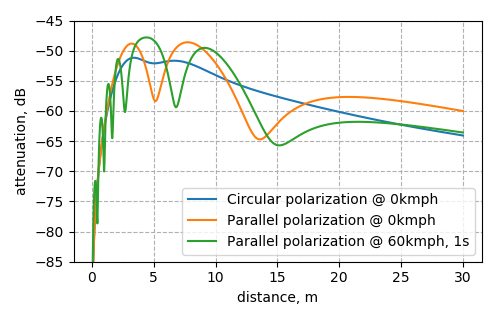

In [15]:
distance = linspace(0., 30, 1000)


pathloss_c0 = [ch.lin2db(two_ray_3d_(d, 0.0, 0, 0.5)) for d in distance]
pathloss_p0 = [ch.lin2db(two_ray_3d_(d, 0.0, 0, 1)) for d in distance]
pathloss_p2 = [ch.lin2db(two_ray_3d_(d, 1., 60/3.6, 1)) for d in distance]

plt.figure(figsize=(5., 3.2))

plt.plot(distance, pathloss_c0, label='Circular polarization @ 0kmph')
plt.plot(distance, pathloss_p0, label='Parallel polarization @ 0kmph')
plt.plot(distance, pathloss_p2, label='Parallel polarization @ 60kmph, 1s')

plt.grid(linestyle='--')
plt.ylim((-85, -45))

plt.ylabel('attenuation, dB')
plt.xlabel('distance, m')

plt.legend()
plt.tight_layout()
# plt.savefig('pathloss_cases.eps')

Example of BER computation.

<IPython.core.display.Javascript object>


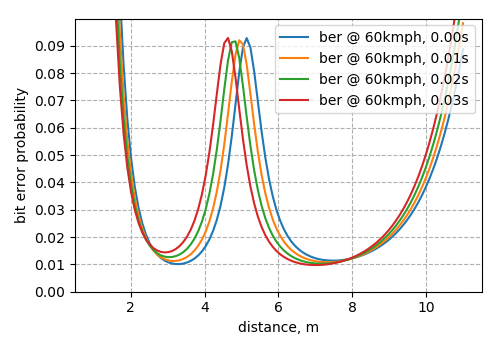

In [21]:
distance  = linspace(1, 11, 100)
ber_0 = [ber_over_rayleigh_3d_(d, 0.00, 60/3.6) for d in distance]
ber_1 = [ber_over_rayleigh_3d_(d, 0.01, 60/3.6) for d in distance]
ber_2 = [ber_over_rayleigh_3d_(d, 0.02, 60/3.6) for d in distance]
ber_3 = [ber_over_rayleigh_3d_(d, 0.03, 60/3.6) for d in distance]

plt.figure(figsize=(5, 3.5))

plt.plot(distance, ber_0, label='ber @ 60kmph, 0.00s')
plt.plot(distance, ber_1, label='ber @ 60kmph, 0.01s')
plt.plot(distance, ber_2, label='ber @ 60kmph, 0.02s')
plt.plot(distance, ber_3, label='ber @ 60kmph, 0.03s')

plt.yticks(np.arange(0.0, 0.1, 0.01))
plt.ylim((0, .1))

plt.ylabel('bit error probability')
plt.xlabel('distance, m')

plt.grid(linestyle='--')
plt.legend()
plt.tight_layout()
# plt.savefig('ber_cases.eps')

Pathloss and link bugdet parameters.

<IPython.core.display.Javascript object>


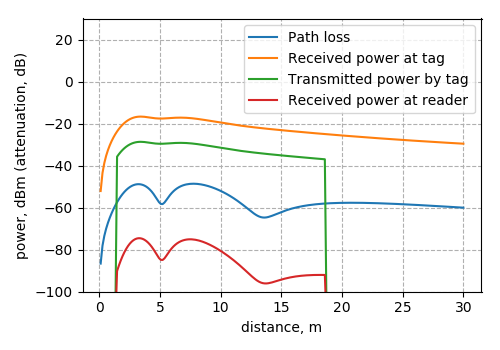

In [25]:
distance = np.linspace(0.1, 30, 200)

pathloss_b = [ch.lin2db(two_ray_3d_(d, 0.0, 0, 1))        for d in distance]
rx_reader  = [rx_power_reader_complete_3d_(d, .0, 60/3.6) for d in distance]
rx_tag     = [rx_power_tag_complete_3d_(d, .0, 60/3.6)    for d in distance]
tx_tag     = [tx_power_tag_complete_3d_(d, .0, 60/3.6)    for d in distance]

plt.figure(figsize=(5, 3.5))

plt.plot(distance, pathloss_b, label='Path loss')
plt.plot(distance, rx_tag,  label='Received power at tag')
plt.plot(distance, tx_tag,  label='Transmitted power by tag')
plt.plot(distance, rx_reader, label='Received power at reader')

plt.ylim((-100,30))

plt.ylabel('power, dBm (attenuation, dB)')
plt.xlabel('distance, m')

plt.grid(linestyle='--')

plt.legend()
plt.tight_layout()
# plt.savefig('link_budget.eps')

Computation on the grid for computation of parameters that ate as follows:
* power incident to tag;
* power incident to reader;
* path loss;
* BER over AWGN channel;
* BER over Rayleigh channel.

Next plots depicting the results are presented

In [26]:
distance = np.linspace(1, 10., 300)
time     = np.linspace(0, 2, 300)

pathloss_greed = ch.lin2db(make_space_time_greed_(distance, time, two_ray_3d_, speed=tag_speed, polarization=1))
rx_tag_greed       = make_space_time_greed_(distance, time, rx_power_tag_complete_3d_, speed=tag_speed)
rx_reader_greed    = make_space_time_greed_(distance, time, rx_power_reader_complete_3d_, speed=tag_speed)
ber_awgn_greed     = make_space_time_greed_(distance, time, ber_over_awgn_3d_, speed=tag_speed)
ber_rayleigh_greed = make_space_time_greed_(distance, time, ber_over_rayleigh_3d_, speed=tag_speed)

<IPython.core.display.Javascript object>


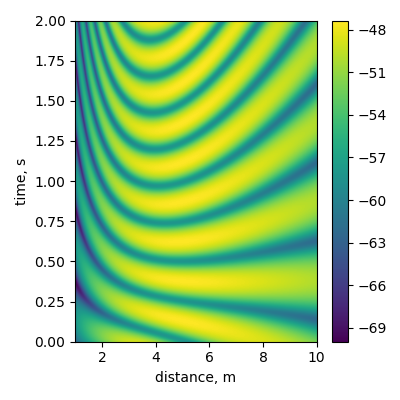

In [56]:
plt.figure(figsize=(4., 4.))

D,T = meshgrid(distance, time)
P = pathloss_greed

im = plt.imshow(P, aspect='auto', interpolation='gaussian',
                origin='lower', extent=[1, 10, 0, 2])

cbar = plt.colorbar(ticks=-3 * np.arange(np.floor(P.max() - P.min()) / 3) + np.floor(P.max()))

# im.axes.set_yticks(.2 * np.arange(11))
im.axes.set_xlabel('distance, m')
im.axes.set_ylabel('time, s')

# plt.title('Bit Error Probability')
plt.tight_layout()
# plt.savefig('pathloss.eps', dpi = 250, facecolor='w', edgecolor='w')

<IPython.core.display.Javascript object>


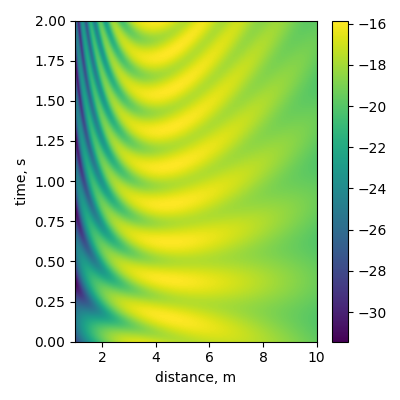

In [57]:
plt.figure(figsize=(4, 4))

D,T = meshgrid(distance, time)
P = rx_tag_greed

im = plt.imshow(P, aspect='auto', interpolation='gaussian',
                origin='lower', extent=[1, 10, 0, 2])

cbar = plt.colorbar(ticks=-2 * np.arange(np.floor(P.max() - P.min()) / 2) + np.floor(P.max()))

# im.axes.set_yticks(0.2*np.arange(11))
im.axes.set_xlabel('distance, m')
im.axes.set_ylabel('time, s')

# plt.title('Bit Error Probability')
plt.tight_layout()
# plt.savefig('rx_tag.eps', dpi = 250, facecolor='w', edgecolor='w')


<IPython.core.display.Javascript object>


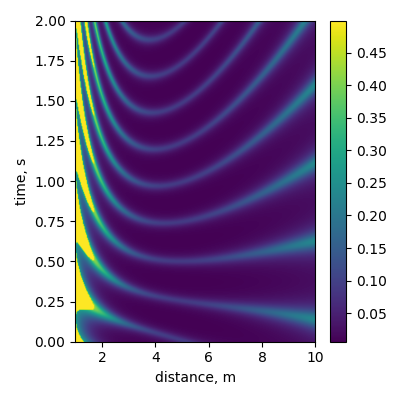

In [67]:
plt.figure(figsize=(4, 4))

D,T = meshgrid(distance, time)
P = ber_rayleigh_greed


im = plt.imshow(P, aspect='auto', interpolation='gaussian',
                origin='lower', extent=[1, 10, 0, 2])

cbar = plt.colorbar(ticks=0.05 * np.arange(10))

# im.axes.set_yticks(0.2*np.arange(11))
im.axes.set_xlabel('distance, m')
im.axes.set_ylabel('time, s')

# plt.title('Bit Error Probability')
plt.tight_layout()
# savefig('ber.eps', dpi = 250, facecolor='w', edgecolor='w')

<IPython.core.display.Javascript object>


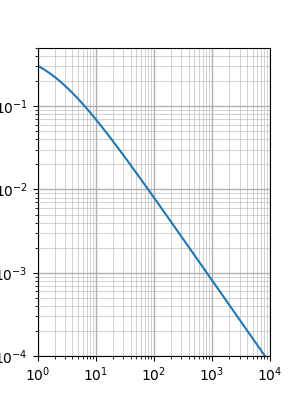

In [87]:
snr = [ch.db2lin(dbm) for dbm in linspace(0, 40, 100)]
ber = [ch.ber_over_rayleigh(snr=snr_i) for snr_i in snr]

plt.figure(figsize=(3, 4))

plt.loglog(snr, ber)

plt.ylim((1e-4, .5))
plt.xlim((.0, 1e4))
plt.grid(linewidth=.4, which='minor')
plt.grid(linewidth=1., which='major')

fig.tight_layout()
# plt.savefig('ber-plot.eps')

<IPython.core.display.Javascript object>


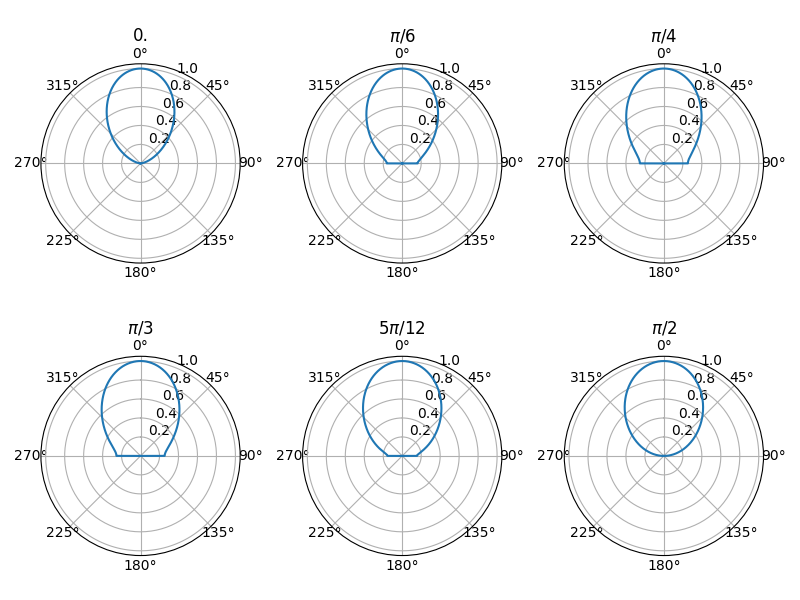

In [102]:
theta = np.linspace(-np.pi, np.pi, 1000)

plt.figure(figsize=(8,6))

angles     = [0., np.pi/6, np.pi/4, np.pi/3, np.pi/12*5, np.pi/2,]
angles_str = ['0.', '$\pi/6$', '$\pi/4$', '$\pi/3$', '$5\pi/12$', '$\pi/2$',]

for i, (angle, a_str) in enumerate(zip(angles, angles_str)):

    r = [patch_rp_(t, angle)  for t in theta]
    
    ax = plt.subplot2grid((2,3), (i // 3, i % 3), projection='polar')    
    ax.plot(theta, r)
    ax.set_theta_zero_location('N')
    ax.set_title(a_str, va='bottom')
    ax.set_theta_direction(-1)
    
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


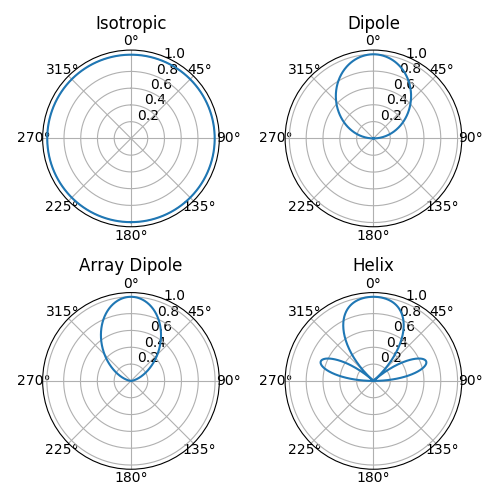

In [106]:
theta = np.linspace(-np.pi, np.pi, 1000)

plt.figure(figsize=(5,5))

rps = [lambda t:    ch.isotropic_rp(azimuth=t), 
       lambda t:       ch.dipole_rp(azimuth=t), 
       lambda t: ch.array_dipole_rp(azimuth=t, n=2), 
       lambda t:        ch.helix_rp(azimuth=t, n=3)]

rps_str = ['Isotropic', 'Dipole', 'Array Dipole', 'Helix']

for i, (rp, rp_str) in enumerate(zip(rps, rps_str)):

    r = [rp(t) for t in theta]
    
    ax = plt.subplot2grid((2,2), (i // 2, i % 2), projection='polar')    
    ax.plot(theta, r)
    ax.set_theta_zero_location('N')
    ax.set_title(rp_str, va='bottom')
    ax.set_theta_direction(-1)
    
plt.tight_layout()
plt.show()